/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


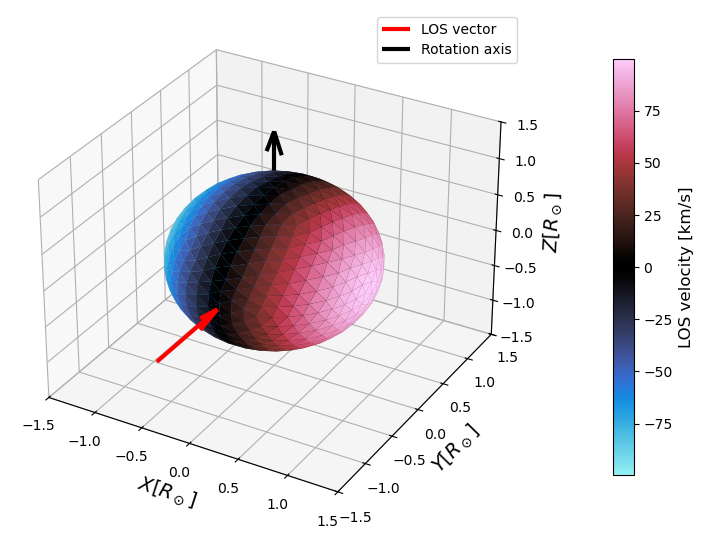

In [1]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
from spice.models.spots import add_spot
from spice.plots import plot_3D
from transformer_payne import Blackbody
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
%matplotlib inline

# Create a blackbody model
bb = Blackbody()

# Set up base parameters
base_temp = 5700
spot_temp = 15000
v_rot = 100  # km/s
rotation_axis = jnp.array([0., 0., 1.])

# Create the icosphere model
m = IcosphereModel.construct(1000, 1., 1., bb.to_parameters(dict(teff=base_temp)), bb.parameter_names)

# Calculate rotation period
r_sun = 696340  # km (solar radius)
circumference = 2 * np.pi * r_sun
period_seconds = circumference / v_rot
TIMESTAMPS = np.linspace(0, period_seconds, 100)

# Add rotation to the model
mt = add_rotation(m, v_rot, rotation_axis)

# Generate a sequence of rotated models at different timestamps
mts = [evaluate_rotation(mt, t) for t in TIMESTAMPS]

# Visualize the model at a specific rotation phase
fig, ax = plot_3D(mts[35], property='los_velocities')

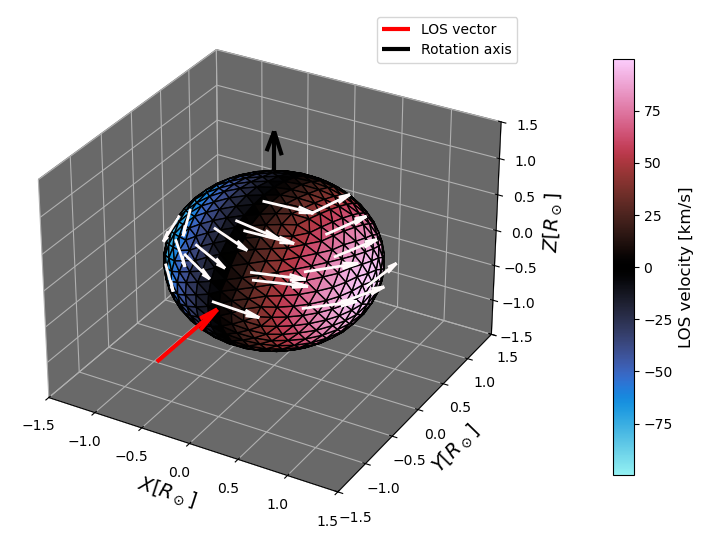

In [3]:
# Create a new figure to show velocity vectors
fig = plt.figure(figsize=(10, 12))
spec = fig.add_gridspec(10, 12)
plot_ax = fig.add_subplot(spec[:, :11], projection='3d')
# Set only the grid background to black, not the entire axis
plot_ax.xaxis.pane.fill = True
plot_ax.yaxis.pane.fill = True
plot_ax.zaxis.pane.fill = True
plot_ax.xaxis.set_pane_color('dimgrey')
plot_ax.yaxis.set_pane_color('dimgrey')
plot_ax.zaxis.set_pane_color('dimgrey')

# Get a specific rotated model
mesh = mts[35]

# Calculate velocity vectors for each mesh element
# Velocity = ω × r where ω is angular velocity vector and r is position vector
angular_velocity = v_rot * rotation_axis / mesh.radius  # Convert to angular velocity in rad/s
velocities = np.cross(angular_velocity, mesh.centers)

# Plot the mesh with los_velocities coloring
to_be_mapped = mesh.los_velocities
cmap = 'cmr.redshift'
norm = plt.Normalize(vmin=to_be_mapped.min(), vmax=to_be_mapped.max())
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Plot the mesh
vs2 = mesh.mesh_elements
face_colors = plt.colormaps[cmap](norm(to_be_mapped))
# Fix: Import mplot3d.art3d instead of using plt.art3d
from mpl_toolkits.mplot3d import art3d
p = art3d.Poly3DCollection(vs2, facecolors=face_colors, edgecolor="black", zorder=2)
plot_ax.add_collection(p)

# Set axis limits and labels
axes_lim = 1.5 * mesh.radius
plot_ax.set_xlim3d(-axes_lim, axes_lim)
plot_ax.set_ylim3d(-axes_lim, axes_lim)
plot_ax.set_zlim3d(-axes_lim, axes_lim)
plot_ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
plot_ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
plot_ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)

# Draw LOS vector
normalized_los_vector = mesh.los_vector/np.linalg.norm(mesh.los_vector)
plot_ax.quiver(*(-2.0*mesh.radius*normalized_los_vector), *(mesh.radius*normalized_los_vector),
           color='red', linewidth=3., label='LOS vector')

# Draw rotation axis
normalized_rotation_axis = mesh.rotation_axis/np.linalg.norm(mesh.rotation_axis)
plot_ax.quiver(*(0.75*mesh.radius*normalized_rotation_axis), *(mesh.radius*normalized_rotation_axis),
            color='black', linewidth=3., label='Rotation axis')

# Add velocity vectors only for mesh elements with mu > 0 (visible hemisphere)
# and in the upper part of the star (z > 0)
visible_mask = (mesh.mus > 0.05) & (mesh.centers[:, 2] > 0)

# Sample every nth point from the visible hemisphere to avoid overcrowding
n = 15
visible_indices = np.where(visible_mask)[0][::n]
# Make velocity vectors more visible by increasing length and width
plot_ax.quiver(mesh.centers[visible_indices, 0], 
               mesh.centers[visible_indices, 1], 
               mesh.centers[visible_indices, 2],
               velocities[visible_indices, 0], 
               velocities[visible_indices, 1], 
               velocities[visible_indices, 2],
               length=0.5, arrow_length_ratio=0.3, zorder=0,
               normalize=True, linewidth=2,
               edgecolors='snow')

# Add colorbar
cbar = fig.colorbar(mappable, shrink=0.45, pad=0.125, ax=plot_ax)
cbar.set_label('LOS velocity [km/s]', fontsize=12)

# Add legend
plot_ax.legend()
